In [1]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

sns.set_style('white')

%matplotlib inline

dump_dir = ''
client = pymongo.MongoClient('localhost', 27017)
db = client.gamesdb

## AI

In [2]:
C = db.turing
cursor = C.find({'task':'AI'})

output_cols = ['user_name', 'opponent', 'color', 'bp', 'wp', 'response', 'rt', 'ts', 'status']

AI = pd.DataFrame(list(cursor))

In [3]:
print(AI.user_name.unique())
AI.head()

['RR' 'SR' 'JC' 'MJ' 'OM' 'CR' 'AV' 'BB']


,_id,bp,color,gi,initials,mt,mxy,opponent,response,rt,status,task,ts,user_name,wp
0,57fba6489100de0961e9c639,000000000000000000000000000000000000,0,0,1476109832464,,,17,99,0,ready,AI,1476109895631,RR,000000000000000000000000000000000000
1,57fba64e9100de0961e9c63a,000000000000010000000000000000000000,0,0,1476109832464,"1476109898467,1476109898477,1476109898487,1476...","322,304;323,302;326,298;327,294;329,291;329,28...",17,13,4013,playing,AI,1476109901690,RR,000000000000000000000000000000000000
2,57fba6549100de0961e9c63b,000000000000010000000100000000000000,0,0,1476109832464,"1476109901690,1476109905593,1476109905603,1476...","965,333;966,334;968,335;969,336;971,338;974,34...",17,21,2503,playing,AI,1476109907286,RR,000000000000100000000000000000000000
3,57fba65a9100de0961e9c63c,000000000000010000000100000001000000,0,0,1476109832464,"1476109907296,1476109907469,1476109907469,1476...","851,493;853,493;853,494;856,495;858,495;862,49...",17,29,2626,playing,AI,1476109913015,RR,000000000000100000001000000000000000
4,57fba6609100de0961e9c63d,000000000000010000000100000011000000,0,0,1476109832464,"1476109913015,1476109913125,1476109913135,1476...","698,627;699,627;700,627;701,627;703,627;707,62...",17,28,3476,playing,AI,1476109919462,RR,000001000000100000001000000000000000


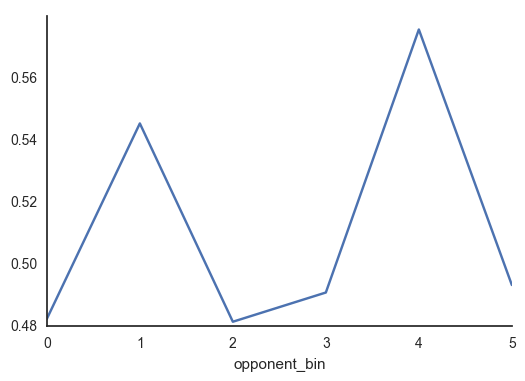

In [4]:
AI_out = AI.loc[AI.status != 'ready', output_cols]
AI_out['new_game'] = AI.bp.map(lambda x: int(np.array(list(x)).astype(int).sum()==1))
AI_out['last_move'] = AI_out['new_game'].shift(-1)
AI_out['status_code'] = AI_out.status.map(lambda x: 1 if x=='win' else 0)
AI_out['opponent'] = AI_out['opponent'].astype(int)
AI_out['opponent_bin'] = AI_out['opponent'] // 5
winfrac = AI_out.loc[AI_out.last_move==1, :].pivot_table(
    index='opponent_bin', values='status_code', aggfunc=np.mean
).sort_index()

winfrac.plot()
sns.despine()

# Turing

In [5]:
cursor = db.test_collection.find({'user_name': {'$in': ['MJ', 'OM', 'CR', 'AV', 'BB','gianni']}})
turing = pd.DataFrame(list(cursor))
turing = turing.loc[:, ['user_name', 'clip_id', 'choice', 'feedback', 'timestamp']]
turing.head()
turing.to_csv(dump_dir + 'turing_pilot.csv')

In [44]:
g = turing.loc[turing.user_name.isin(['MJ', 'OM', 'BB', 'AV']), :] # 'gianni'
g['correct'] = g['feedback'].map(lambda x: x=='true').astype(int)
g['correct'] = g['correct'].astype(int)
sts.bayes_mvs(g.correct, alpha=.95) #.loc[g.user_name=='BB', :]

(Mean(statistic=0.52380952380952384, minmax=(0.2908562898221122, 0.75676275779693547)),
 Variance(statistic=0.29100529100529093, minmax=(0.15329691245760654, 0.54615960978511002)),
 Std_dev(statistic=0.53201229152894602, minmax=(0.39153149612464966, 0.73902612253228905)))

In [32]:
g.loc[g.user_name=='gianni', 'choice'].values.astype(int).size

96

LinregressResult(slope=-0.0037701386286998779, intercept=55.311405254777071, rvalue=-0.0047663172843010956, pvalue=0.96323956356561502, stderr=0.081584096915791812)


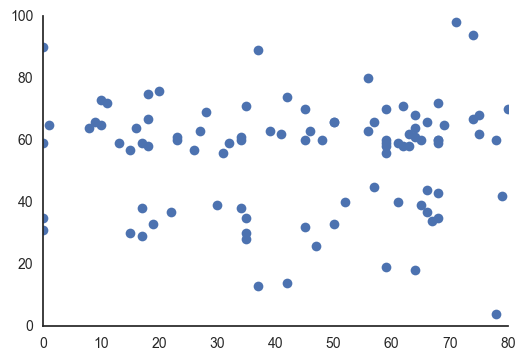

In [41]:
x = g.loc[g.user_name=='BB', 'choice'].values.astype(int)
y = g.loc[g.user_name=='gianni', 'choice'].values.astype(int)
print(sts.linregress(x, y))
plt.plot(
    x, 
    y, 
    linestyle='none', marker='o'
)

sns.despine()

In [42]:
BB = g.loc[g.user_name=='BB', :]
print(sts.linregress(BB.choice.astype(int), BB.correct.astype(int)))

LinregressResult(slope=-0.0017997644917839752, intercept=0.74570632393084624, rvalue=-0.086974910919928705, pvalue=0.39944556658541497, stderr=0.0021262233129241532)


## One offs:

(correcting errors)

In [87]:
# EXAMPLE: replace user_name field to be correct

F = {'user_name': }
U = {'$set': {'user_name': 'MJ'}}

C.update(F, U, multi=True)

{'n': 404, 'nModified': 404, 'ok': 1, 'updatedExisting': True}

In [19]:
# EXAMPLE: remove test user from database

F = {'user_name': {'$in': ['gianni', 'bas', 'test']}}

C.remove(F, multi=True)

{'n': 13, 'ok': 1}